## test+train的Fat data全用來當word2vec的訓練文本
## 不考慮出現"not"的情況( "not" 在model中相關字的意思和"not"沒有太大相關性)

In [1]:
from os import listdir
from os.path import isfile, isdir, join
from collections import Counter
import csv
import numpy
import pandas as pd
from gensim.models.word2vec import Word2Vec
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from data_preprocess import content_fraction
from Dataloader import dataloader

In [2]:
train_data_path = "..\Case_Presentation_1_Data\Train_Textual\\"
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"

train_data = dataloader(train_data_path)
test_data  = dataloader(test_data_path)

In [3]:
#print(train_data.text_list[0])

### 取train data和test data中"非肥胖"的text

In [4]:
model = Word2Vec(test_data.text_list[200:400])

In [5]:
#定義相關性
def similar(w2v_model, word, target, topn=10):
        try:
            return w2v_model.wv.similarity(word, target)
        except:
            return 0

In [6]:
#找和 words相關性最大的前 [topn] 個字
def most_similar(w2v_model, words, topn=20):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

### 和"not"相關的前幾個字和"not"本身文義不相關

In [7]:
print(most_similar(model, ["not"]))

                   not       cos
0   treatmentsprocedur  0.901894
1               detail  0.898373
2                 none  0.898035
3             procedur  0.885477
4                 oper  0.874877
5              remaind  0.870707
6                brief  0.860218
7              uncompl  0.852147
8               cather  0.850845
9              rouxeni  0.846358
10              commun  0.835323
11              suicid  0.834182
12                want  0.830900
13                 see  0.830488
14               cours  0.828857
15             surgeri  0.827696
16              hospit  0.824811
17          laparoscop  0.824219
18               taken  0.822183
19         colonoscopi  0.818089


In [8]:
print(most_similar(model, ["hypercholesterolemia"]))

   hypercholesterolemia       cos
0                reflux  0.995003
1                  gout  0.994248
2         gastroesophag  0.992497
3        hyperlipidemia  0.990710
4                   osa  0.989671
5                peptic  0.989611
6                anemia  0.989147
7          dyslipidemia  0.989082
8               depress  0.988814
9                 stent  0.986285
10                 iddm  0.986057
11               vessel  0.985737
12             idiopath  0.984940
13          hypothyroid  0.984901
14               asthma  0.983600
15                 copd  0.983019
16        insulindepend  0.982901
17           osteoarthr  0.982201
18               mother  0.982077
19           neuropathi  0.981017


In [9]:
print(most_similar(model, ["angina"]))

            angina       cos
0          unstabl  0.993714
1            chief  0.987583
2             copd  0.985696
3          infarct  0.983426
4            viral  0.983085
5          exacerb  0.983031
6           stroke  0.981149
7         myocardi  0.981124
8        secondari  0.980760
9             cabg  0.980405
10       cholecyst  0.980060
11          recent  0.979148
12            like  0.977991
13       bronchiti  0.977855
14         diagnos  0.976500
15      osteoarthr  0.976439
16          cellul  0.976343
17         problem  0.975366
18  cardiomyopathi  0.974893
19            atyp  0.974590


---------------------------------------------------------------------------------------------------------------------------

## 計分方式

In [10]:
def score(datakind, gap, target_word):
    score=0
    total = 0
    for text in datakind:
        for word in text:
            if similar(model, word,  target_word)>gap:
                score+=similar(model, word, target_word)
        total+=score
        score=0
    average = total/200
    return average

### [gap]定義在大於多少相識性時要承認
### [target_word]定義要以哪個字為中心找相關性

In [11]:
gap = 0.85
target_word = "angina"

# Train data

## 不肥胖

In [12]:
train_unfat_score = score(train_data.text_list[0:200], gap, target_word)
print("train_unfat_score: ",train_unfat_score)

train_unfat_score:  147.64209533602


## 肥胖

In [13]:
train_fat_score = score(train_data.text_list[200:400], gap, target_word)
print("train_fat_score: ",train_fat_score)

train_fat_score:  161.85315084248782


# Test data

## 不肥胖

In [14]:
test_unfat_score = score(test_data.text_list[0:200], gap, target_word)
print("test_unfat_score: ",test_unfat_score)

test_unfat_score:  150.2221712693572


## 肥胖

In [15]:
test_fat_score =score(test_data.text_list[200:400], gap, target_word)
print("test_fat_score: ",test_fat_score)

test_fat_score:  153.88608200043439


In [16]:
upper = (train_fat_score+test_fat_score)/2
print("upper: ",upper)

upper:  157.8696164214611


In [17]:
lower =  (train_unfat_score+test_unfat_score)/2
print("lower: ",lower)

lower:  148.9321333026886


### standard 建立判斷文章是否為Fat 的標準分數。 大於standard即為Fat，反之不是

In [18]:
standard = (upper+lower)/2
print("standard: ",standard)

standard:  153.40087486207486


---------------------------------------------------------------------------------------------------------------------------

# Validation

In [19]:
validation_data_path  = "..\Case_Presentation_1_Data\Validation\\"
validation_data  = dataloader(validation_data_path)

In [20]:
score(validation_data.text_list, gap, target_word)

41.284995380342004

In [21]:
score=0
ans = []
for text in validation_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        ans.append(0)
    else:
        ans.append(1)
    score=0

print(len(ans))

50


In [22]:
print(ans)

[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [23]:
len(validation_data.text_list)

50

---------------------------------------------------------------------------------------------------------------------------

# confusion matrix & F1-score

In [24]:
from sklearn.metrics import confusion_matrix

def precision(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[0,1])

def recall(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[1,0])


def f1(matrix):
    return (2*precision(matrix)*recall(matrix))/(precision(matrix)+recall(matrix))


def confusionMatix(matrix, title):
    sns.set()
    f,ax=plt.subplots()
    #y_true = label
    #y_pred = ans
    sns.heatmap(matrix,annot=True,ax=ax, cmap = plt.cm.Blues) #畫熱力圖

    ax.set_title(title) #標題
    ax.set_xlabel('predict') #x軸
    ax.set_ylabel('true') #y軸

def print_result(matrix, title):
    print("precision: ",precision(matrix))
    print("recall: ",recall(matrix))
    print("F1-Score: ",f1(matrix))
    confusionMatix(matrix, title)
    
        

---------------------------------------------------------------------------------------------------------------------------

## train data

In [25]:
train_data_path  = "..\Case_Presentation_1_Data\Train_Textual\\"
train_data  = dataloader(train_data_path)
score=0
train_ans = []
for text in train_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        train_ans.append(0)
    else:
        train_ans.append(1)
    score=0

In [26]:
train_y_true = train_data.label_list
train_y_pred = train_ans

train_confusion_matrix = confusion_matrix(train_y_true, train_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(train_confusion_matrix[i][j])/200
train_confusion_matrix = tmp

precision:  0.375
recall:  0.4464285714285714
F1-Score:  0.4076086956521739


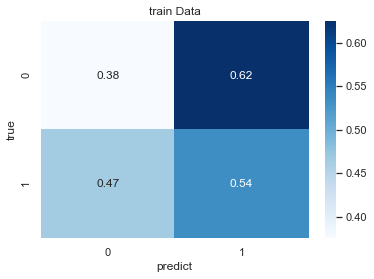

In [27]:
print_result(train_confusion_matrix, "train Data")

## test data

In [28]:
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"
test_data  = dataloader(test_data_path)
score=0
test_ans = []

for text in test_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        test_ans.append(0)
    else:
        test_ans.append(1)
    score=0

In [29]:
test_y_true = test_data.label_list
test_y_pred = test_ans

test_confusion_matrix = confusion_matrix(test_y_true, test_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(test_confusion_matrix[i][j])/200
test_confusion_matrix = tmp

precision:  0.4
recall:  0.4878048780487805
F1-Score:  0.43956043956043955


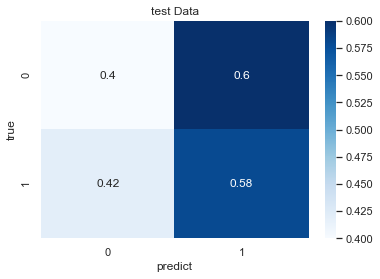

In [30]:
print_result(test_confusion_matrix, "test Data")